**Goal:** Is to develop a machine learning approach to make predictions on the House Price which is a regression task.

**Information about the House**

- Id - Unique ID for each home sold
- date - Date of the home sale
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where 5. accounts for a room with a toilet but no shower.
- sqft_living - Square footage of the apartment interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors/level (e.g ground floor, 1st floor)
- waterfront - This indicates whether the apartment was overlooking the waterfront or not(1 = Yes waterfront; 0 = No waterfront)
- view - An index of 0-4 (0-Bad view, 1-ok view, 2-Semi view, 3-Good view, 4-Very good view) of how good the view of the property is.
- condition - An index of 0-5 (0-Bad condition, 1-ok condition, 2-Semi condition, 3-Good condition, 4-Very good condition) on the condition of the apartment
- grade - An index from 1-13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, 11-13 have a high quality of construction and design 
- sqft_above - Square footage of the interior housing space that is above ground level
- sqft_basement - Square footage of the interior housing space that is below level
- yr_built - The year the house was initially built
- yr_renovated - The year of the house's last renovation
- zipcode - The zipcode area where the house is located
- lat - Latitude of the house
- lon - Longitude of the house
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land space for the nearest 15 neighbors

**Price(Target)** - Price of each home sold

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (22, 10)

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

# Exploratory Data Analysis and Preparation

In [2]:
data_path = r'/home/daniel/Desktop/programming/pythondatascience/datascience/datascienceprojects/datasets'
dataset = 'kc_house_data.csv'
data = pd.read_csv(f"{data_path}/{dataset}", header = 0)
print(data.shape)
data.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## Converting the Datetime feature to the right format

In [4]:
data['date'] = pd.to_datetime(data.date)

# Target Exploration (Price)

It is crucial to understand it in detail as this is what we are trying to predict accurately.

In [5]:
data.groupby('price').first()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,,,,,,,,,,,,,,,,,,,,
75000.0,3421079032,2015-02-17,1,0.00,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882
78000.0,40000362,2014-05-06,2,1.00,780,16344,1.0,0,0,1,5,780,0,1942,0,98168,47.4739,-122.280,1700,10387
80000.0,8658300340,2014-05-23,1,0.75,430,5050,1.0,0,0,2,4,430,0,1912,0,98014,47.6499,-121.909,1200,7500
81000.0,3028200080,2015-03-24,2,1.00,730,9975,1.0,0,0,1,5,730,0,1943,0,98168,47.4808,-122.315,860,9000
82000.0,3883800011,2014-11-05,3,1.00,860,10426,1.0,0,0,3,6,860,0,1954,0,98146,47.4987,-122.341,1140,11250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5350000.0,8907500070,2015-04-13,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
5570000.0,2470100110,2014-08-04,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
6890000.0,9208900037,2014-09-19,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


In [6]:
data.groupby('price')['price'].mean().sort_values(ascending = False)

price
7700000.0    7700000.0
7060000.0    7060000.0
6890000.0    6890000.0
5570000.0    5570000.0
5350000.0    5350000.0
               ...    
82000.0        82000.0
81000.0        81000.0
80000.0        80000.0
78000.0        78000.0
75000.0        75000.0
Name: price, Length: 3625, dtype: float64

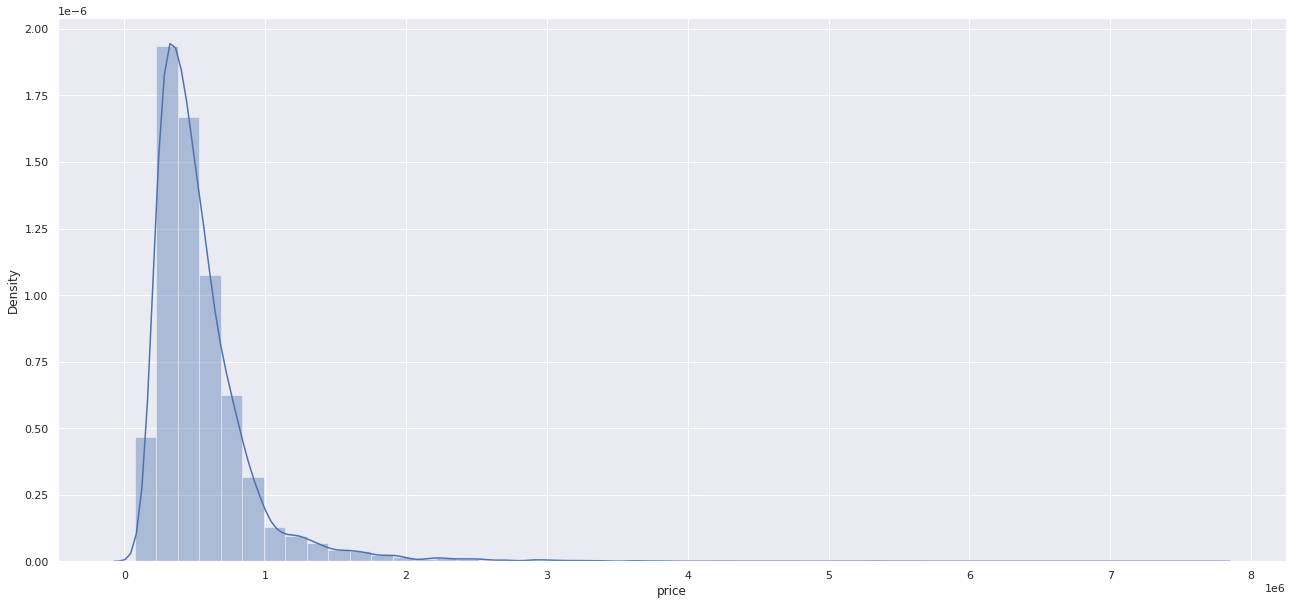

In [7]:
sns.distplot(data.price)
plt.show()

The price has a right skewed distribution and can create problems during predictions.

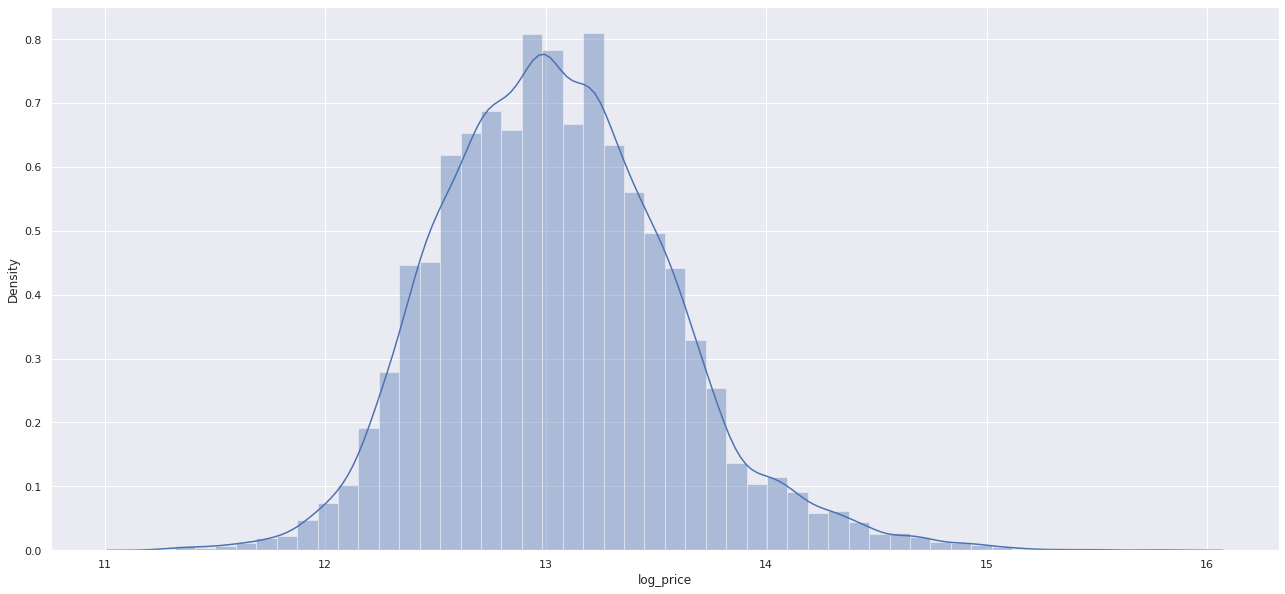

In [8]:
data['log_price'] = np.log(np.array(data.price) + 1)
sns.distplot(data.log_price)
plt.show()

Now, the price follows a **Guassian distribution.**

# Check for Outliers

In [9]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.401822e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.396058,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,13.047889
std,2.876566e+09,3.673622e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.089843,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,0.526821
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,11.225257
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,12.682155
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,13.017005
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,13.377007
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,15.856731


# Outlier Detection and Treatment

## IQR (Inter Quantile Range) for Outlier Detection

In [10]:
def detect_outliers(df, col, remove_outlier = True):
    
    """
    Function to detect the presence of Outliers in a column
    when remove_outler = False or to remove 
    Outliers when remove_outler = True
    
    Args:
        df (Dataframe) : dataframe of the data
        col (string) : column name of the data
    
    Returns:
        float : detected outliers
    """
    
    if remove_outlier:
        # 1st quantile is 1%
        Q1 = df[col].quantile(0.01)
        # 3rd quantile is 99%
        Q3 = df[col].quantile(0.99)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR

        return df.loc[~((df[col] < lower_limit) | (df[col] > upper_limit))]
    
    else:
        
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.99)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR

        return df.loc[((data[col] < lower_limit) | (df[col] > upper_limit))]

### Bedrooms

In [11]:
detect_outliers(data, 'bedrooms', remove_outlier = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
15870,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700,13.369225


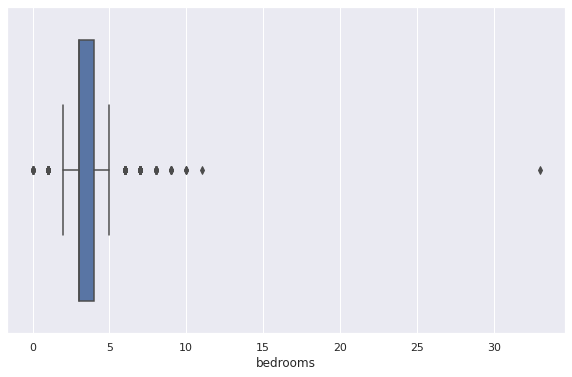

In [12]:
plt.figure(figsize = (10, 6))
sns.boxplot(data.bedrooms)
plt.show()

### Bathrooms

In [13]:
detect_outliers(data, 'bathrooms', remove_outlier = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price


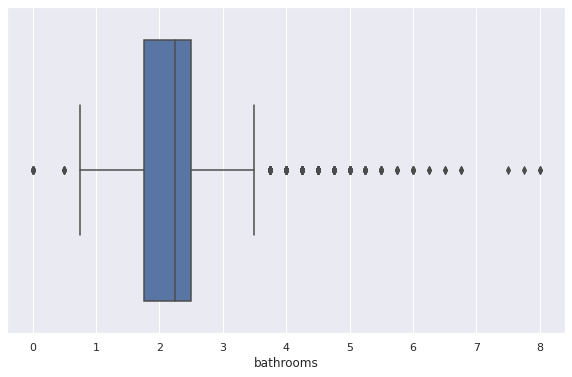

In [14]:
plt.figure(figsize = (10, 6))
sns.boxplot(data.bathrooms)
plt.show()

### sqft_living

In [15]:
detect_outliers(data, 'sqft_living', remove_outlier = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
7252,6762700020,2014-10-13,7700000.0,6,8.0,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,15.856731
12777,1225069038,2014-05-05,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800,14.639686


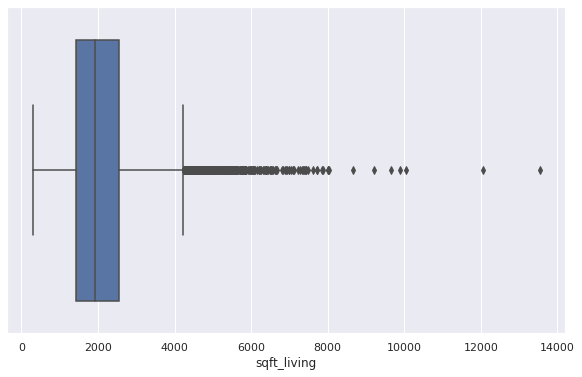

In [16]:
plt.figure(figsize = (10, 6))
sns.boxplot(data.sqft_living)
plt.show()

### sqft_lot

In [17]:
detect_outliers(data, 'sqft_lot', remove_outlier = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
1719,1020069017,2015-03-27,700000.0,4,1.00,1300,1651359,1.0,0,3,4,6,1300,0,1920,0,98022,47.2313,-122.023,2560,425581,13.458837
3949,722069232,2014-09-05,998000.0,4,3.25,3770,982998,2.0,0,0,3,10,3770,0,1992,0,98058,47.4140,-122.087,2290,37141,13.813510
4441,3626079040,2014-07-30,790000.0,2,3.00,2560,982278,1.0,0,0,3,8,2560,0,2004,0,98014,47.6955,-121.861,1620,40946,13.579789
4540,2522029039,2014-09-29,550000.0,3,2.00,3650,843309,2.0,0,0,4,7,3650,0,1991,0,98070,47.3627,-122.496,1870,273992,13.217675
6691,2624089007,2015-03-20,2000000.0,2,2.50,3900,920423,2.0,0,0,3,12,3900,0,2009,0,98065,47.5371,-121.756,2720,411962,14.508658
7077,2724079090,2015-01-05,1650000.0,4,3.25,3920,881654,3.0,0,3,3,11,3920,0,2002,0,98024,47.5385,-121.896,2970,112384,14.316286
7294,1923039022,2014-11-20,700000.0,2,1.75,1679,577605,2.0,0,0,3,9,1679,0,2001,0,98070,47.4630,-122.475,1850,358934,13.458837
7647,2623069031,2014-05-21,542500.0,5,3.25,3010,1074218,1.5,0,0,5,8,2010,1000,1931,0,98027,47.4564,-122.004,2450,68825,13.203945
7769,2323089009,2015-01-19,855000.0,4,3.50,4030,1024068,2.0,0,0,3,10,4030,0,2006,0,98045,47.4619,-121.744,1830,11700,13.658858
9714,225079036,2015-01-07,937500.0,4,4.00,5545,871200,2.0,0,0,3,11,3605,1940,2003,0,98014,47.6760,-121.882,3420,871200,13.750973


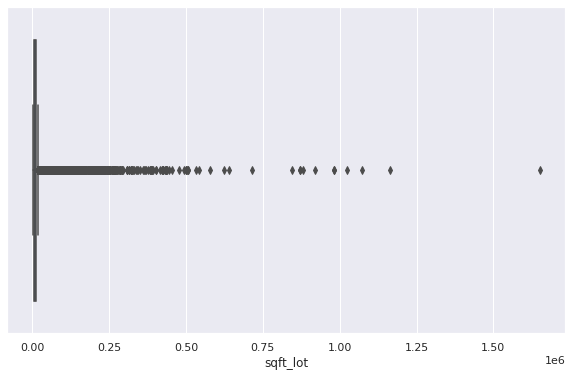

In [18]:
plt.figure(figsize = (10, 6))
sns.boxplot(data.sqft_lot)
plt.show()

In [19]:
# Remove outlier from sqft_lot
data = detect_outliers(data, 'sqft_lot', remove_outlier = True)

### floors

In [20]:
detect_outliers(data, 'floors', remove_outlier = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price


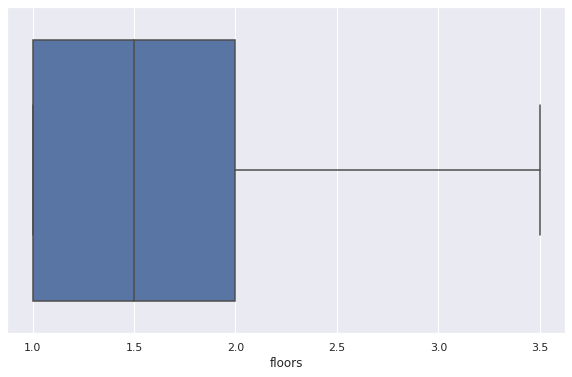

In [21]:
plt.figure(figsize = (10, 6))
sns.boxplot(data.floors)
plt.show()

### sqft_above

In [22]:
detect_outliers(data, 'sqft_above', remove_outlier = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price


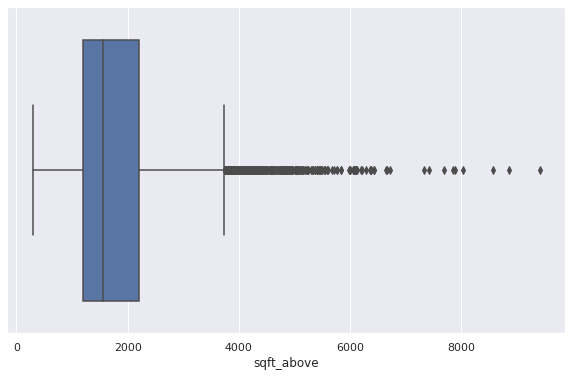

In [23]:
plt.figure(figsize = (10, 6))
sns.boxplot(data.sqft_above)
plt.show()

### sqft_basement

In [24]:
detect_outliers(data, 'sqft_basement', remove_outlier = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
8092,1924059029,2014-06-17,4670000.0,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.557,-122.21,3270,10454,15.35667


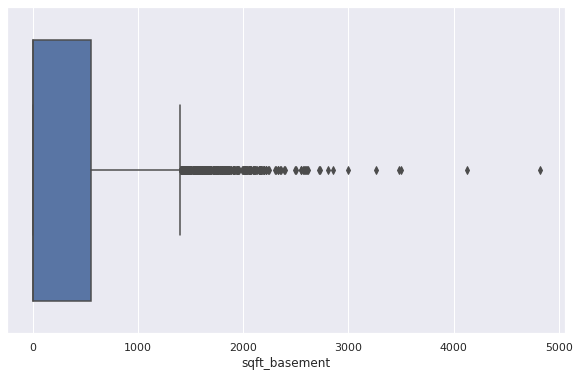

In [25]:
plt.figure(figsize = (10, 6))
sns.boxplot(data.sqft_basement)
plt.show()

### lat

In [26]:
detect_outliers(data, 'lat', remove_outlier = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price


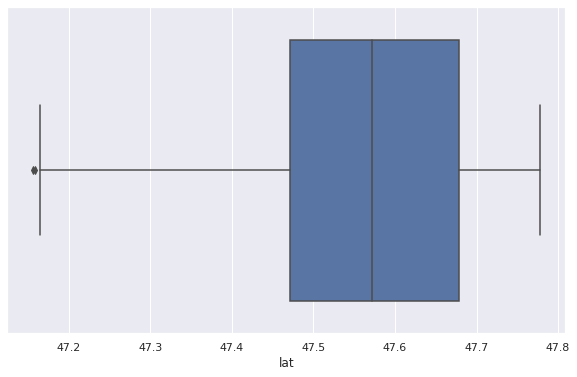

In [27]:
plt.figure(figsize = (10, 6))
sns.boxplot(data.lat)
plt.show()

### long

In [28]:
detect_outliers(data, 'long', remove_outlier = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price


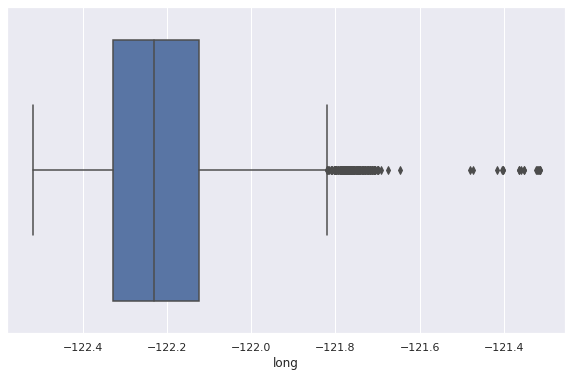

In [29]:
plt.figure(figsize = (10, 6))
sns.boxplot(data.long)
plt.show()

### sqft_living15

In [30]:
detect_outliers(data, 'sqft_living15', remove_outlier = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price


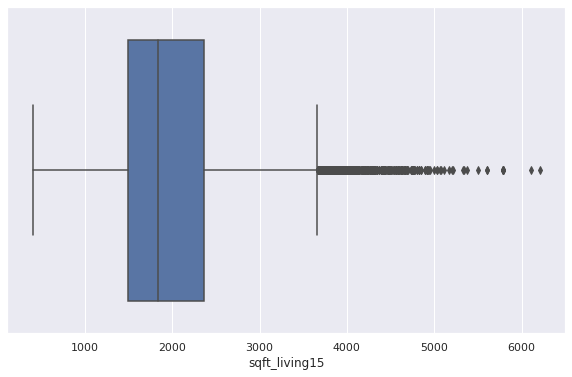

In [31]:
plt.figure(figsize = (10, 6))
sns.boxplot(data.sqft_living15)
plt.show()

### sqft_lot15

In [32]:
detect_outliers(data, 'sqft_lot15', remove_outlier = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
3801,1550000463,2014-08-26,637000.0,4,3.50,3080,118918,2.0,0,0,3,9,3080,0,2008,0,98019,47.7721,-121.924,1830,434728,13.364527
8664,3226079059,2014-10-19,549950.0,3,1.75,2930,266587,2.0,0,0,3,8,2440,490,1995,0,98014,47.6991,-121.947,2700,438213,13.217584
11183,1422029117,2014-07-11,319000.0,3,1.75,1640,53400,1.0,0,0,4,7,1640,0,1966,0,98070,47.3944,-122.506,1850,380279,12.672950
13464,3420069060,2014-11-07,790000.0,3,2.50,2640,432036,1.5,0,3,3,10,2640,0,1996,0,98022,47.1795,-122.036,1500,560617,13.579789
15620,2225079030,2014-12-12,180000.0,2,1.00,960,87991,1.5,0,0,3,5,960,0,1946,0,98014,47.6300,-121.900,1940,392040,12.100718
17659,620079042,2015-03-23,370000.0,2,1.00,2360,105850,1.0,0,2,2,6,1180,1180,1947,0,98022,47.2495,-121.970,2640,386812,12.821261
19156,1020069042,2014-10-01,858000.0,4,3.50,4370,422967,1.0,0,2,4,10,2580,1790,1978,0,98022,47.2332,-122.029,3260,422967,13.662361
21431,2725079018,2014-05-09,800000.0,4,3.25,3540,159430,2.0,0,0,3,9,3540,0,2007,0,98014,47.6285,-121.899,1940,392040,13.592368


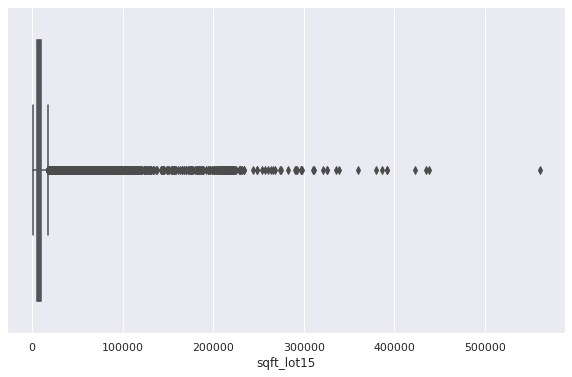

In [33]:
plt.figure(figsize = (10, 6))
sns.boxplot(data.sqft_lot15)
plt.show()

In [34]:
# Remove outlier from sqft_lot15
data = detect_outliers(data, 'sqft_lot15', remove_outlier = True)

# Check for Missing Values

In [35]:
data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
log_price        0
dtype: int64

# Feature Analysis & Extraction

## Univariant Feature Analysis

In [36]:
print(data.nunique())

id               21411
date               372
price             3624
bedrooms            13
bathrooms           30
sqft_living       1035
sqft_lot          9760
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         943
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             70
lat               5027
long               749
sqft_living15      777
sqft_lot15        8672
log_price         3624
dtype: int64


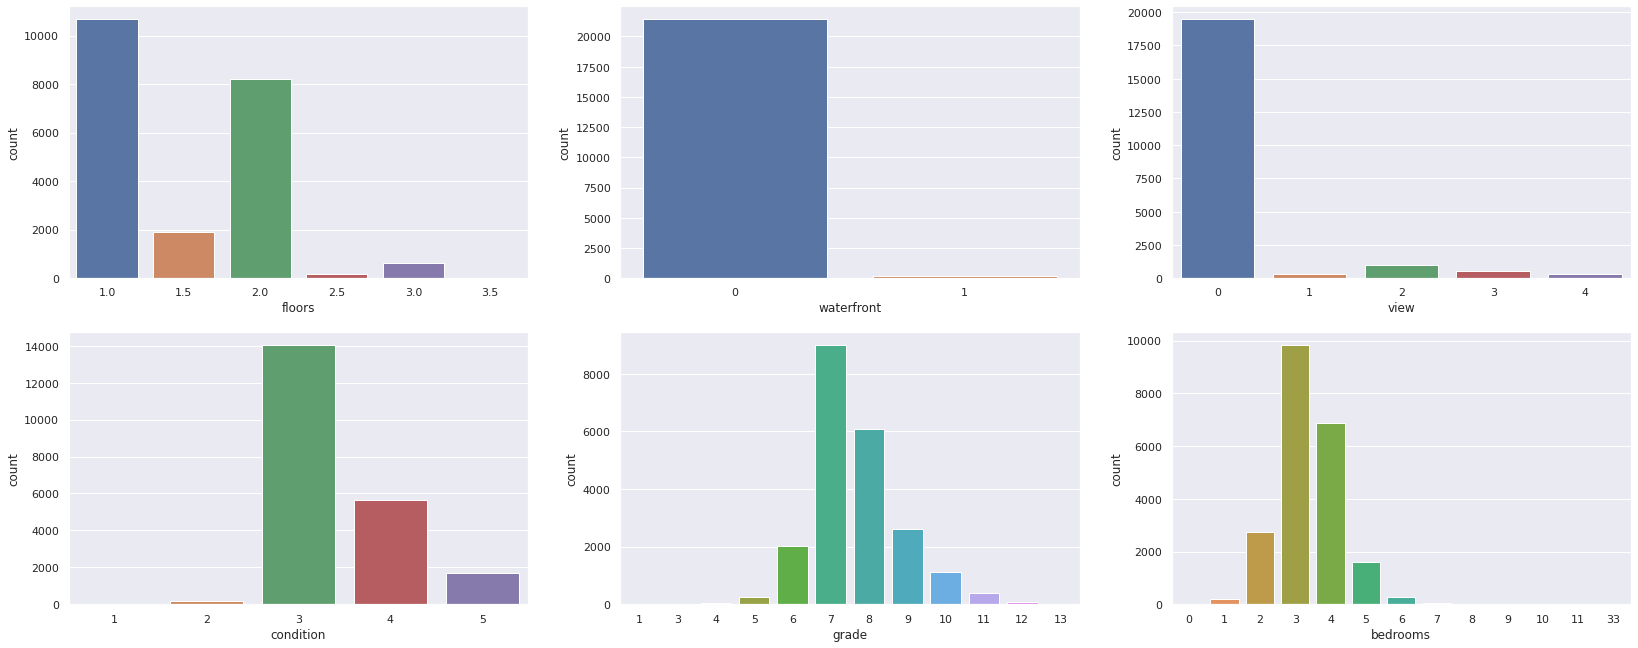

In [37]:
fig, ax = plt.subplots(2, 3, figsize = (28, 11))
sns.countplot(x = 'floors', data = data, ax = ax[0][0])
sns.countplot(x = 'waterfront', data = data, ax = ax[0][1])
sns.countplot(x = 'view', data = data, ax = ax[0][2])
sns.countplot(x = 'condition', data = data, ax = ax[1][0])
sns.countplot(x = 'grade', data = data, ax = ax[1][1])
sns.countplot(x = 'bedrooms', data = data, ax = ax[1][2])
plt.show()

In [38]:
data.waterfront.value_counts()

0    21425
1      163
Name: waterfront, dtype: int64

Observations: 
1. Ground floors are the most across buildings.
2. Almost every apartment has no waterfront.
3. Majority of the apartments has a very bad view.
4. Most of the buildings are in good condition.
5. Most apartments has an average construction and design.
6. 3 bedroom flat are the most across apartments.

# Datetime Feature

In [39]:
data.date.min(), data.date.max()

(Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))

Clearly, this dataset is for 12 months (1 year) from the year of 2014 to 2015 of the month of May. To look at trends, we need to extract the days and months of the apartments.

In [40]:
data['date_day_of_week'] = data.date.dt.dayofweek
data['date_day_name'] = data.date.apply(lambda x: x.day_name())
data['date_month'] = data.date.dt.month
data['date_month_name'] = data.date.apply(lambda x: x.month_name())
data['date_week_of_year'] = data.date.dt.weekofyear
data['date_year_quarter'] = data.date.dt.quarter

In [41]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price,date_day_of_week,date_day_name,date_month,date_month_name,date_week_of_year,date_year_quarter
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,12.309987,0,Monday,10,October,42,4
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,13.195616,1,Tuesday,12,December,50,4
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,12.100718,2,Wednesday,2,February,9,1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,13.311331,1,Tuesday,12,December,50,4
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,13.142168,2,Wednesday,2,February,8,1


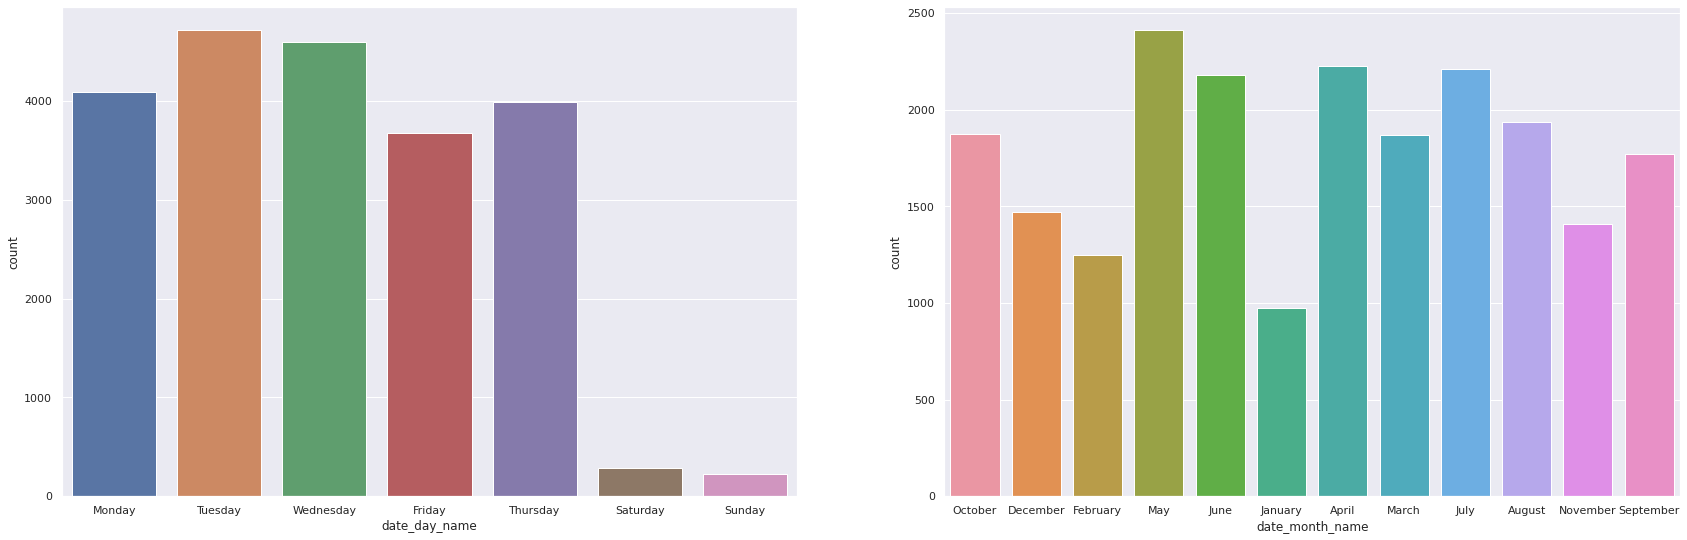

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (29, 9))
sns.countplot(x = 'date_day_name', data = data, ax = ax[0])
sns.countplot(x = 'date_month_name', data = data, ax = ax[1])
plt.show()

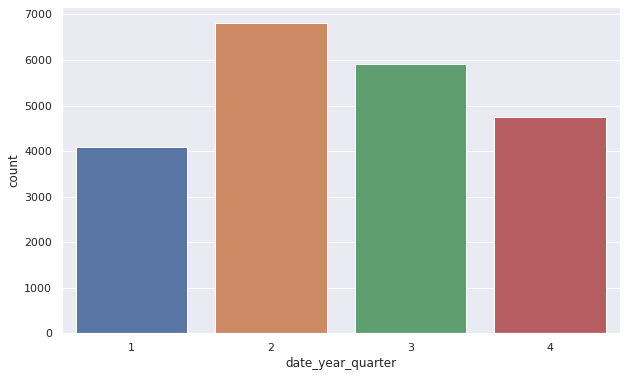

In [43]:
plt.figure(figsize = (10, 6))
sns.countplot(x = 'date_year_quarter', data = data)
plt.show()

# Latitude and Longitude

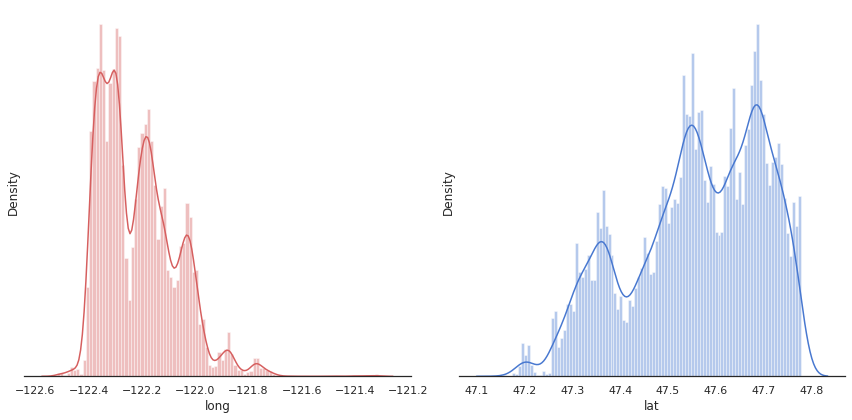

In [44]:
sns.set(style = 'white', palette = 'muted', color_codes = True)
fig, axes = plt.subplots(1, 2, figsize = (12,6), sharex = False, sharey = False)
sns.despine(left = True)

sns.distplot(data.long, color = 'r', label = 'long', bins = 100, ax = axes[0])
sns.distplot(data.lat, color = 'b', label = 'lat', bins = 100, ax = axes[1])

plt.setp(axes, yticks = [])
plt.tight_layout()
plt.show()

# Bivariate relationship with the Target feature (Price)

In [45]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price,date_day_of_week,date_day_name,date_month,date_month_name,date_week_of_year,date_year_quarter
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,12.309987,0,Monday,10,October,42,4
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,13.195616,1,Tuesday,12,December,50,4
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,12.100718,2,Wednesday,2,February,9,1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,13.311331,1,Tuesday,12,December,50,4
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,13.142168,2,Wednesday,2,February,8,1


# Price vs Bedroom

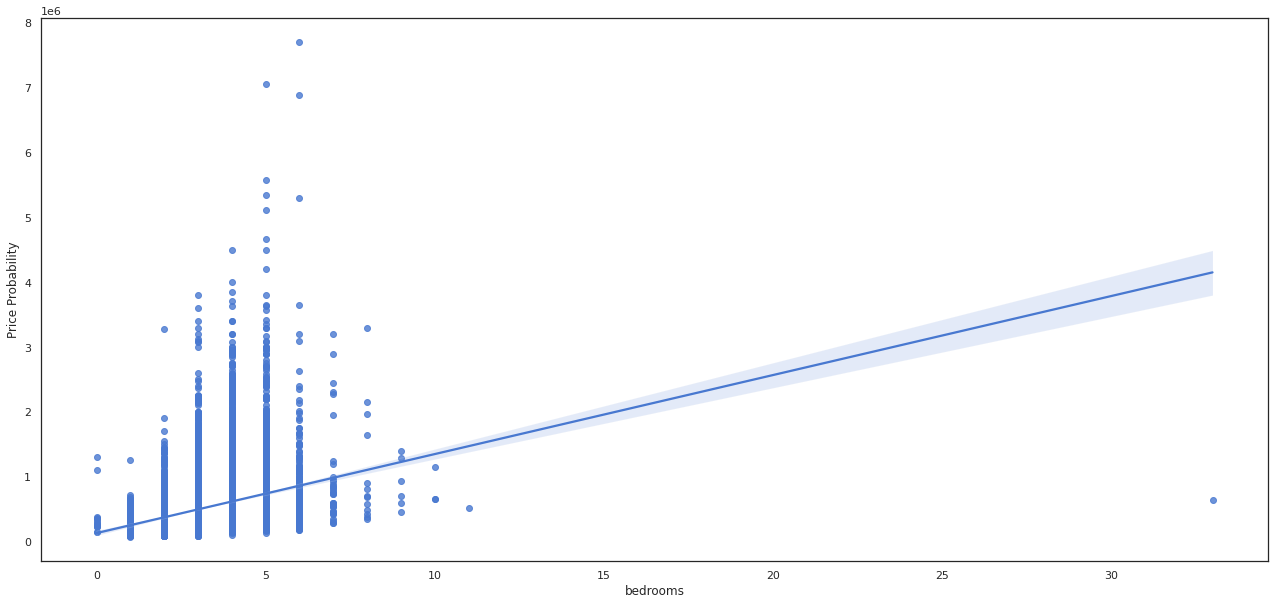

In [46]:
c = sns.regplot(y = 'price', x = 'bedrooms', data = data)
c.set_ylabel('Price Probability')
plt.show()

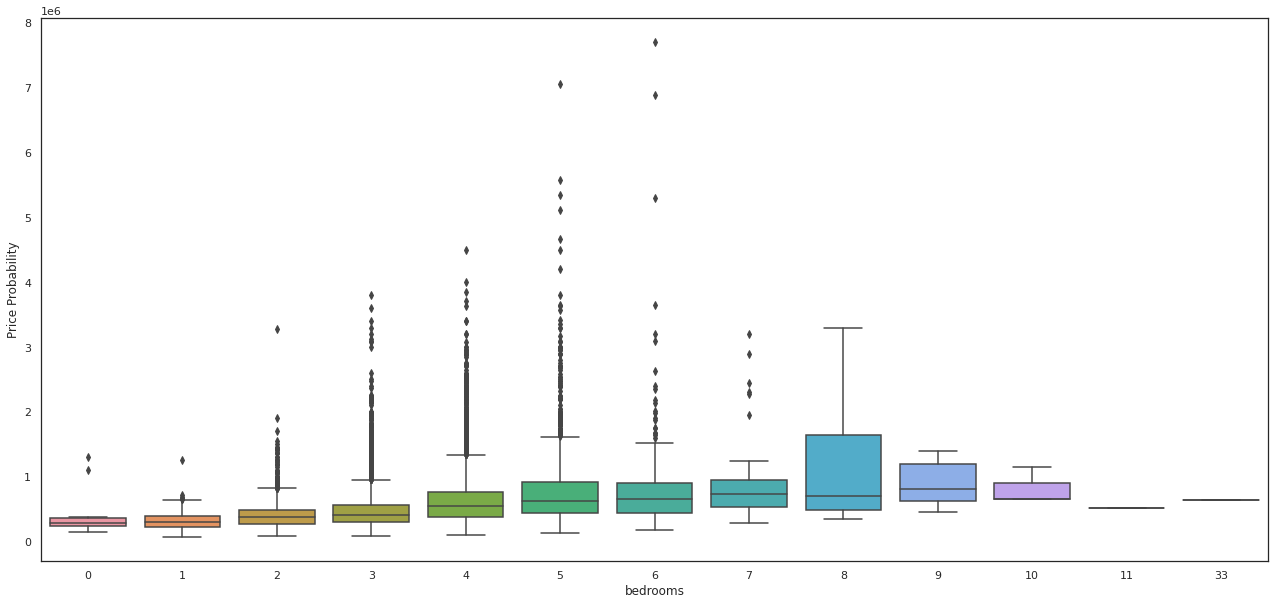

In [47]:
c = sns.boxplot(y = 'price', x = 'bedrooms', data = data)
c.set_ylabel('Price Probability')
plt.show()

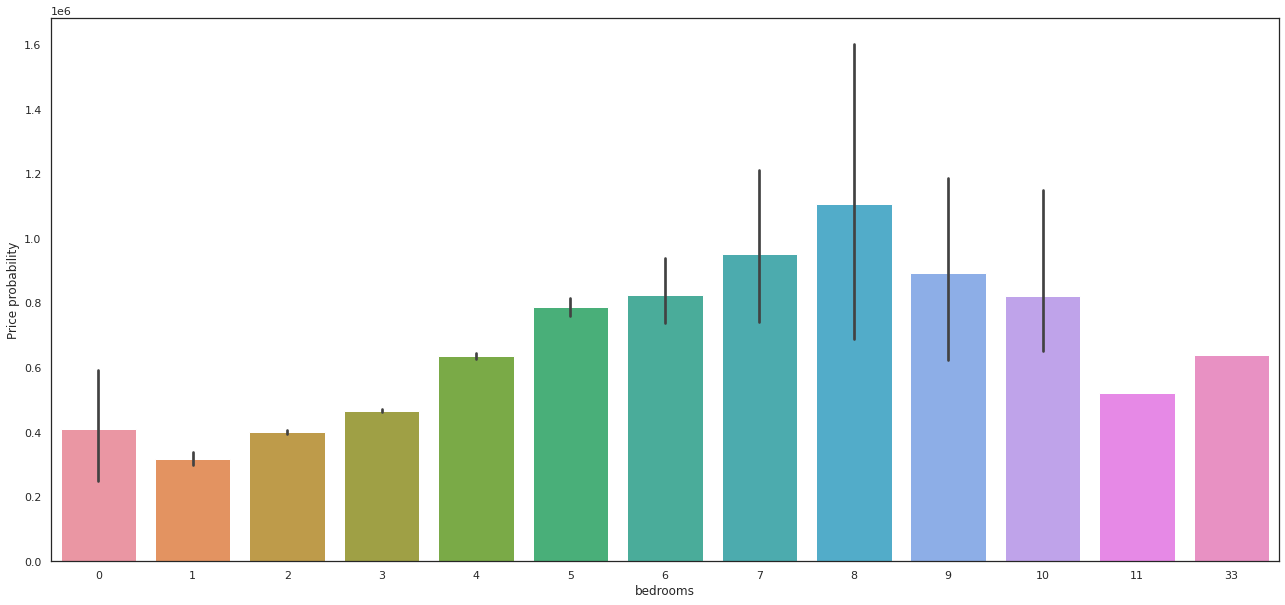

In [48]:
c = sns.barplot(y = 'price', x = 'bedrooms', data = data)
c.set_ylabel('Price probability')
plt.show()

Observation: This shows that apartments with 8 rooms are the most expensive.
- The relationship is not linear.

# Price vs Bathrooms

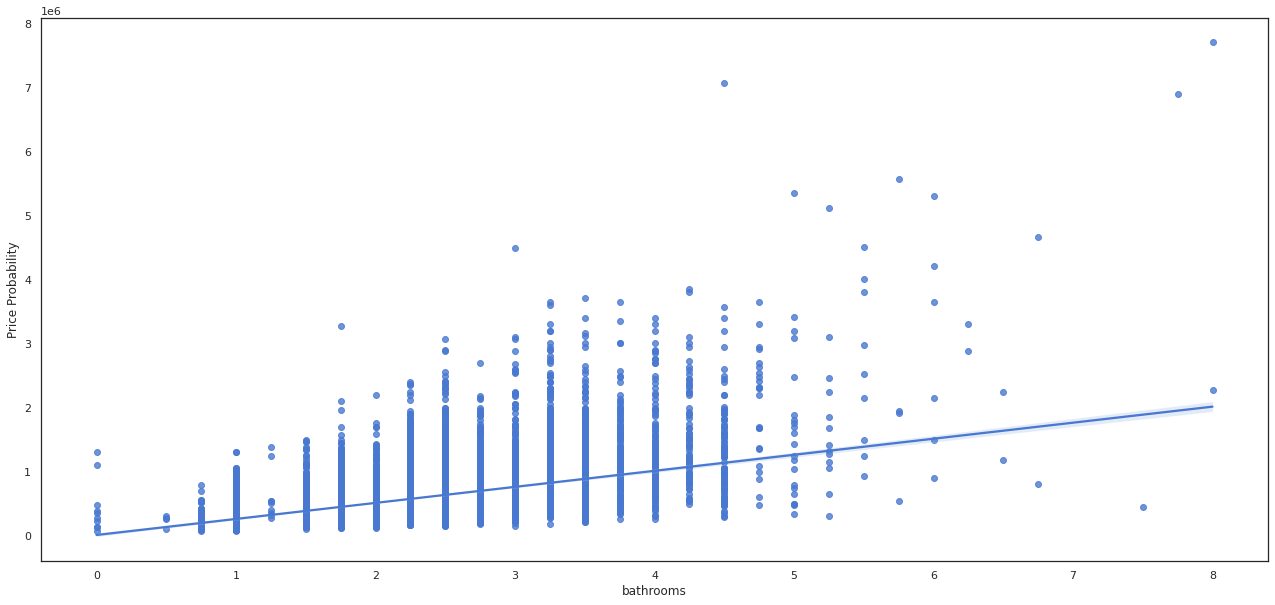

In [49]:
c = sns.regplot(y = 'price', x = 'bathrooms', data = data)
c.set_ylabel('Price Probability')
plt.show()

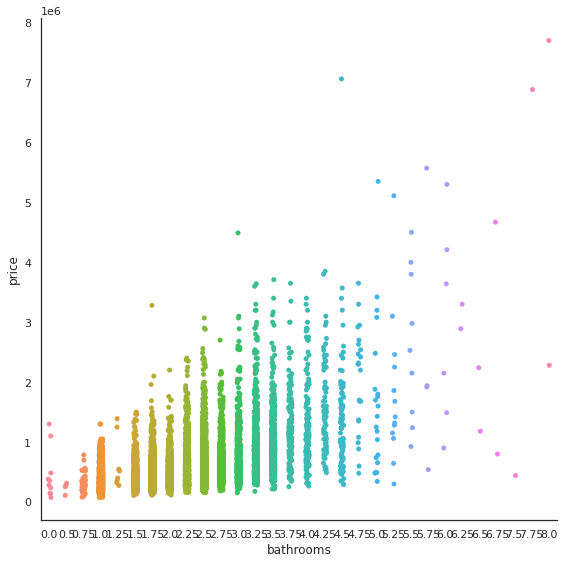

In [50]:
sns.catplot(y = 'price', x = 'bathrooms', data = data, height = 8)
plt.show()

There is a linear relationship between Price and bathrooms.

# Price vs sqft_living

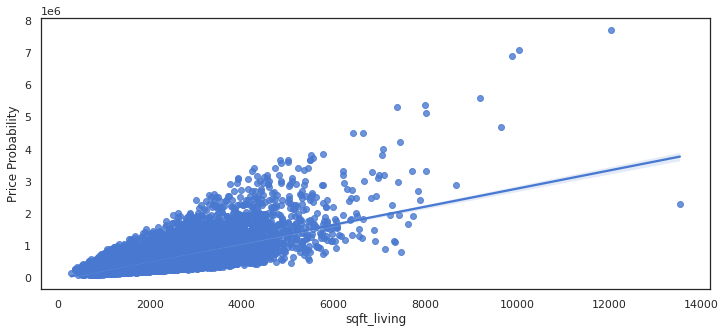

In [51]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'sqft_living', data = data)
c.set_ylabel('Price Probability')
plt.show()

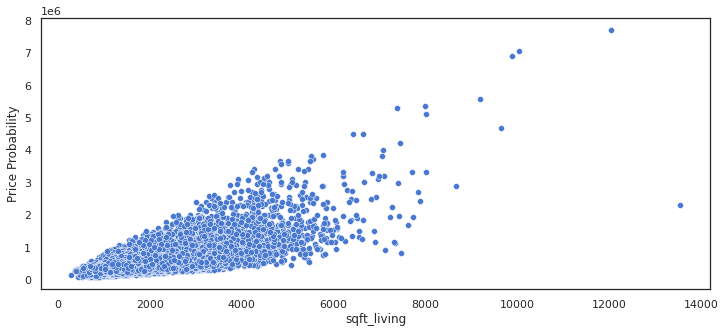

In [52]:
plt.figure(figsize = (12, 5))
c = sns.scatterplot(y = 'price', x = 'sqft_living', data = data)
c.set_ylabel('Price Probability')
plt.show()

There is a linear relationship between Price and sqft_living.

# Price vs sqft_lot

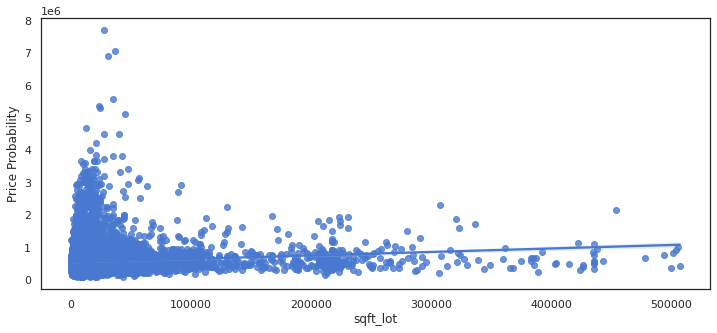

In [53]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'sqft_lot', data = data)
c.set_ylabel('Price Probability')
plt.show()

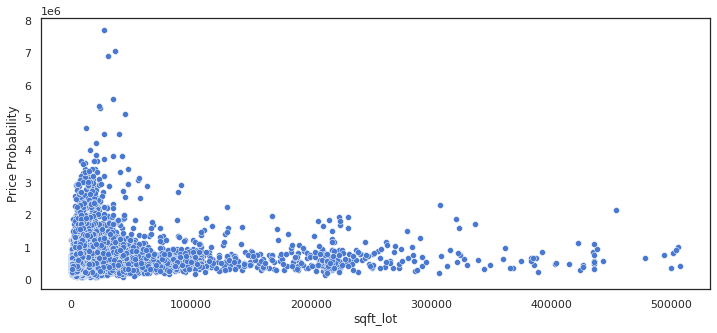

In [54]:
plt.figure(figsize = (12, 5))
c = sns.scatterplot(y = 'price', x = 'sqft_lot', data = data)
c.set_ylabel('Price Probability')
plt.show()

There is no linear relationship between the price and sqft_lot.

# Price vs floors

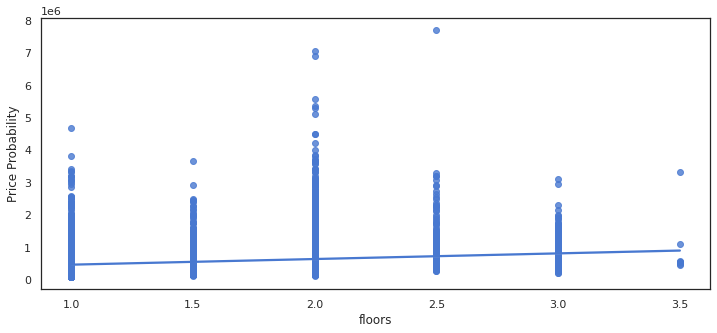

In [55]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'floors', data = data)
c.set_ylabel('Price Probability')
plt.show()

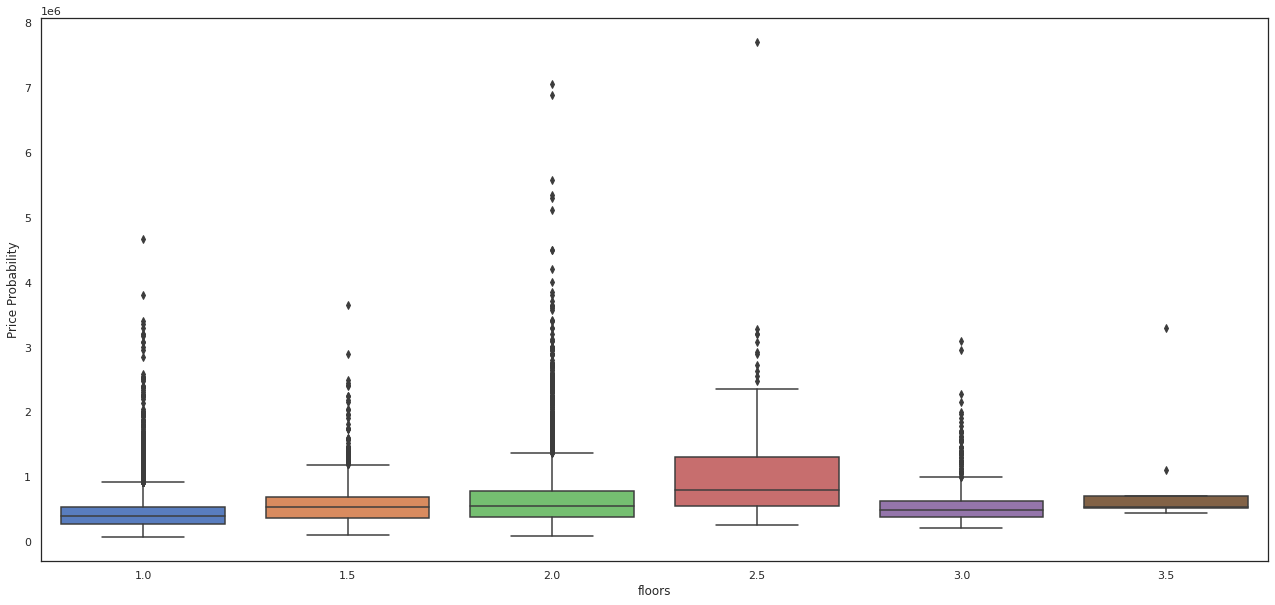

In [56]:
c = sns.boxplot(y = 'price', x = 'floors', data = data)
c.set_ylabel('Price Probability')
plt.show()

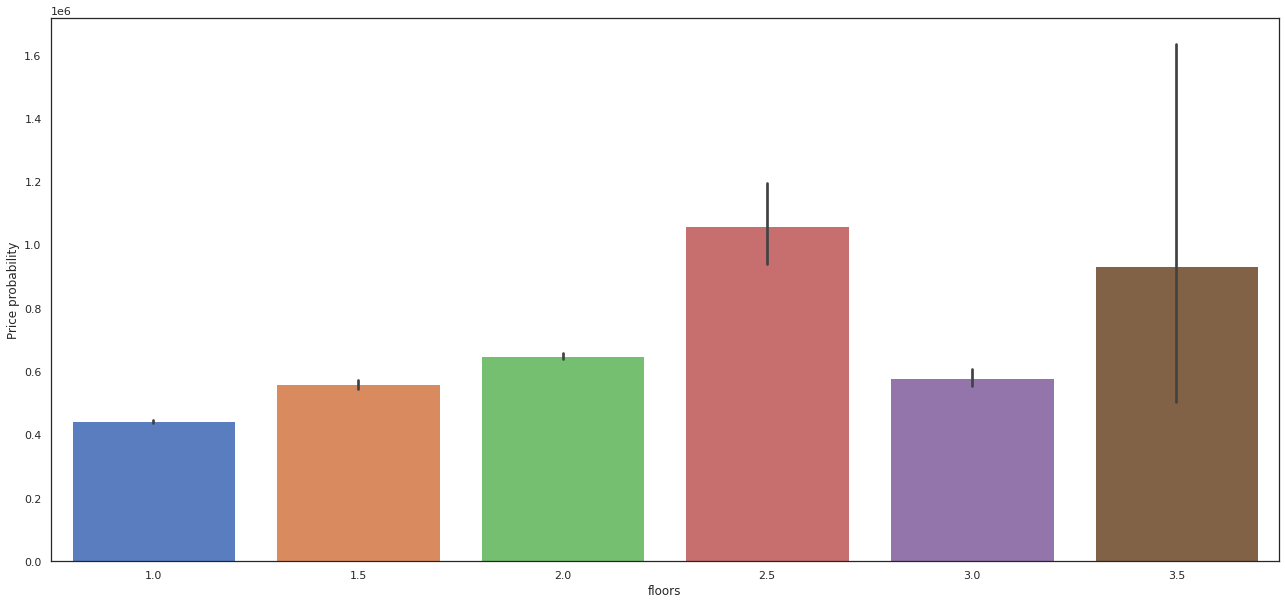

In [57]:
c = sns.barplot(y = 'price', x = 'floors', data = data)
c.set_ylabel('Price probability')
plt.show()

# Price vs waterfront

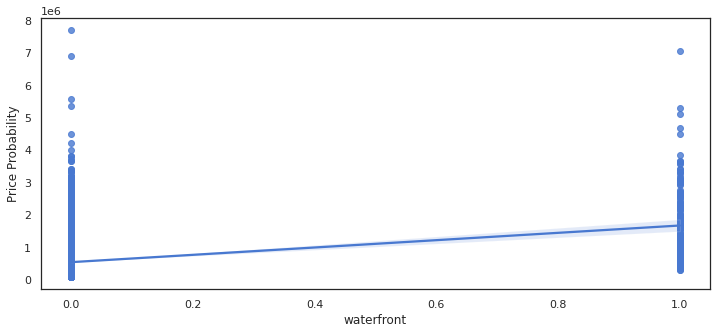

In [58]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'waterfront', data = data)
c.set_ylabel('Price Probability')
plt.show()

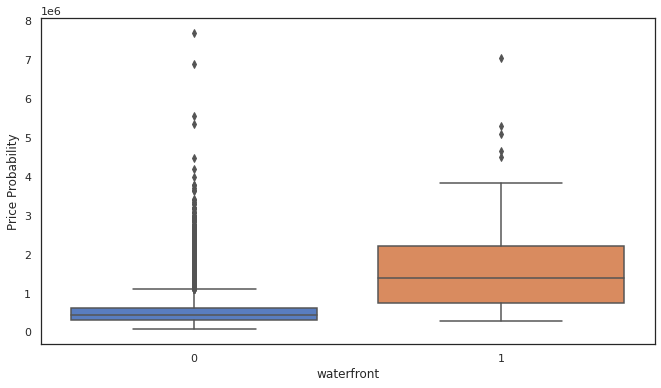

In [59]:
plt.figure(figsize = (11, 6))
c = sns.boxplot(y = 'price', x = 'waterfront', data = data)
c.set_ylabel('Price Probability')
plt.show()

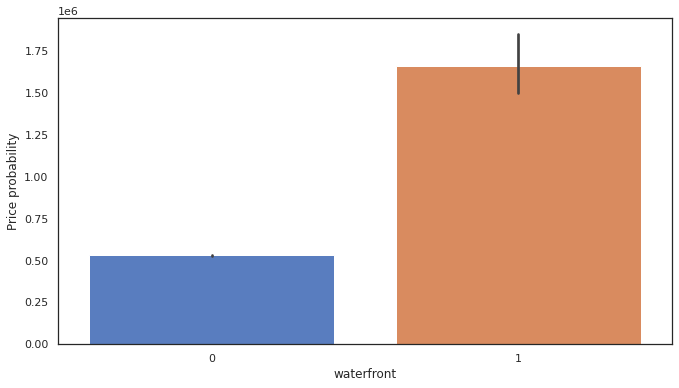

In [60]:
plt.figure(figsize = (11, 6))
c = sns.barplot(y = 'price', x = 'waterfront', data = data)
c.set_ylabel('Price probability')
plt.show()

# Price vs view

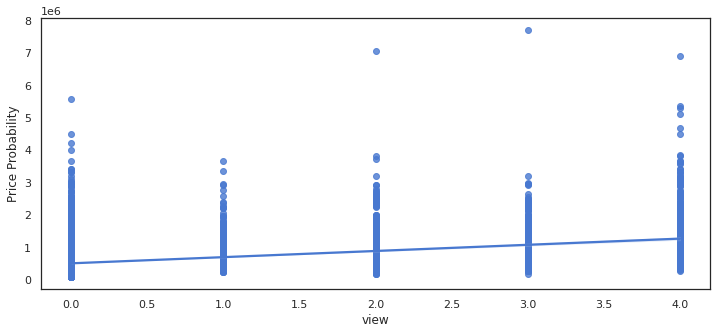

In [61]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'view', data = data)
c.set_ylabel('Price Probability')
plt.show()

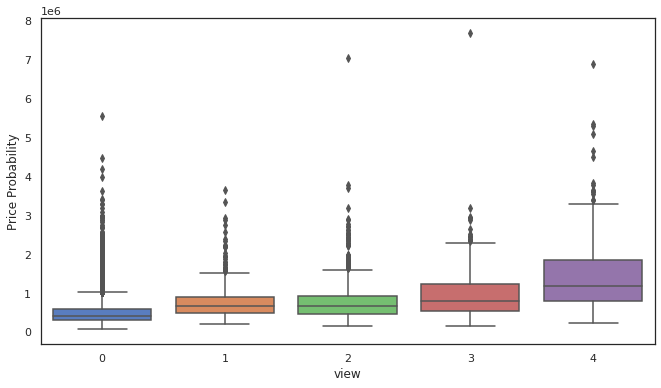

In [62]:
plt.figure(figsize = (11, 6))
c = sns.boxplot(y = 'price', x = 'view', data = data)
c.set_ylabel('Price Probability')
plt.show()

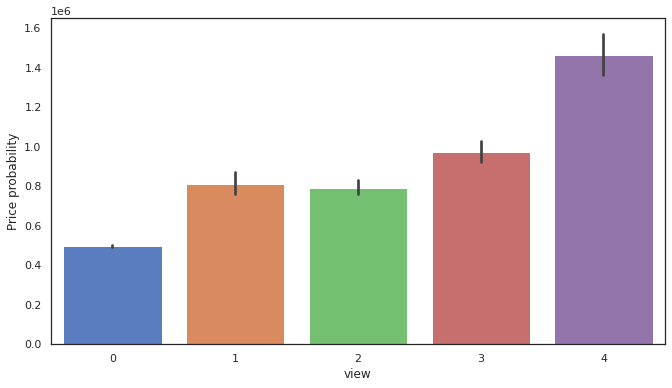

In [63]:
plt.figure(figsize = (11, 6))
c = sns.barplot(y = 'price', x = 'view', data = data)
c.set_ylabel('Price probability')
plt.show()

The relationship between the price and views seems linear

# Price vs condition

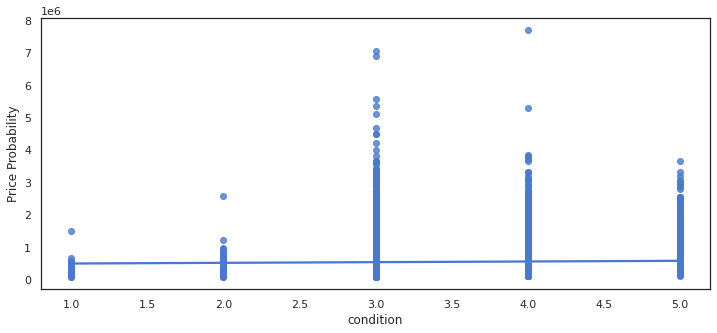

In [64]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'condition', data = data)
c.set_ylabel('Price Probability')
plt.show()

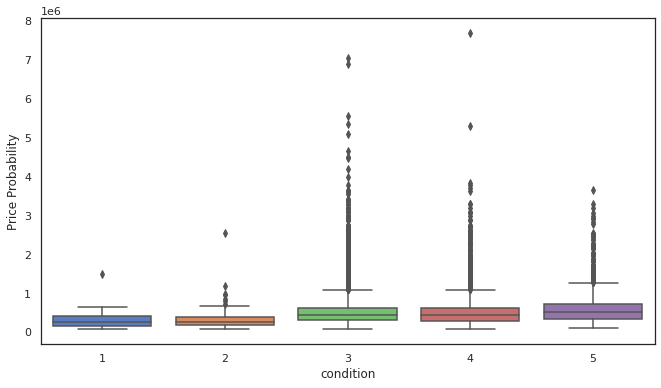

In [65]:
plt.figure(figsize = (11, 6))
c = sns.boxplot(y = 'price', x = 'condition', data = data)
c.set_ylabel('Price Probability')
plt.show()

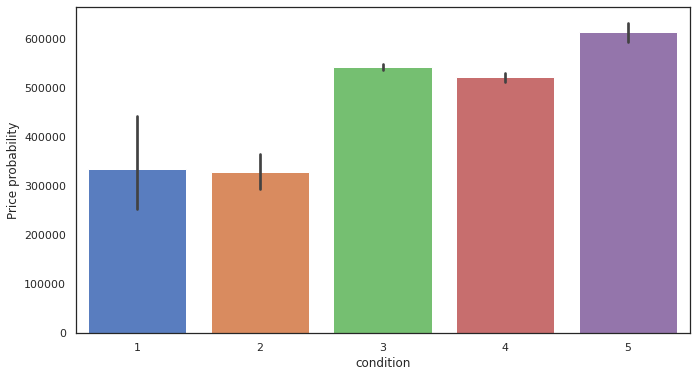

In [66]:
plt.figure(figsize = (11, 6))
c = sns.barplot(y = 'price', x = 'condition', data = data)
c.set_ylabel('Price probability')
plt.show()

# Price vs grade

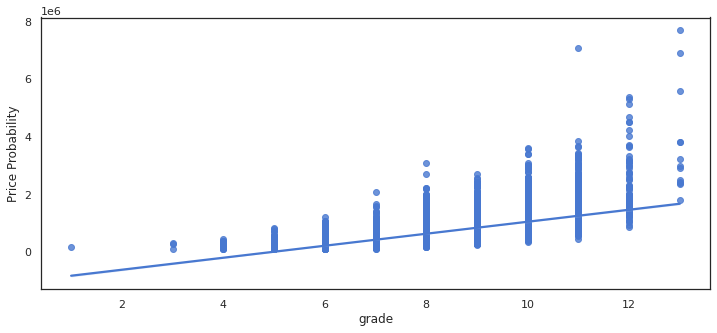

In [67]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'grade', data = data)
c.set_ylabel('Price Probability')
plt.show()

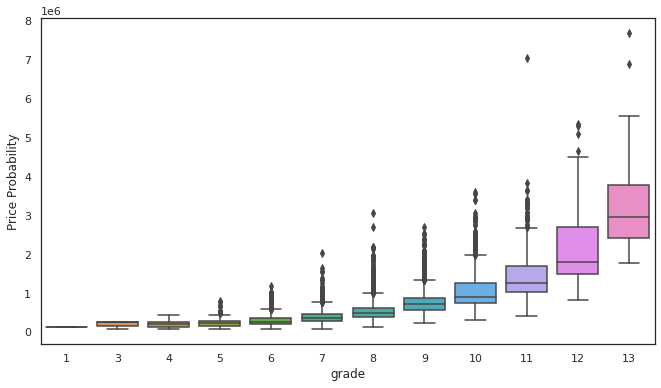

In [68]:
plt.figure(figsize = (11, 6))
c = sns.boxplot(y = 'price', x = 'grade', data = data)
c.set_ylabel('Price Probability')
plt.show()

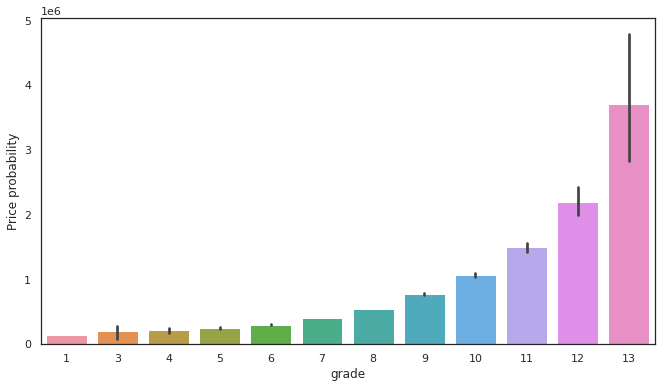

In [69]:
plt.figure(figsize = (11, 6))
c = sns.barplot(y = 'price', x = 'grade', data = data)
c.set_ylabel('Price probability')
plt.show()

There is a linear relationship between Price and Grade.

# Price vs sqft_above

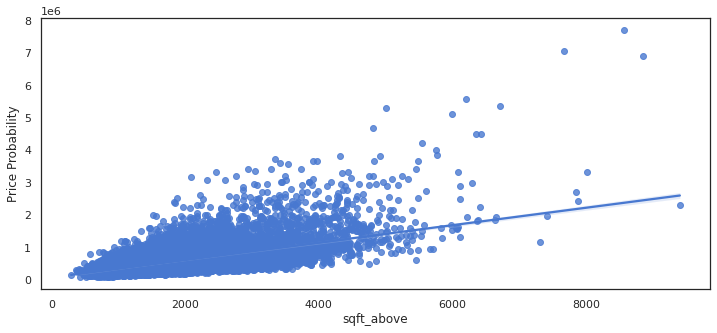

In [70]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'sqft_above', data = data)
c.set_ylabel('Price Probability')
plt.show()

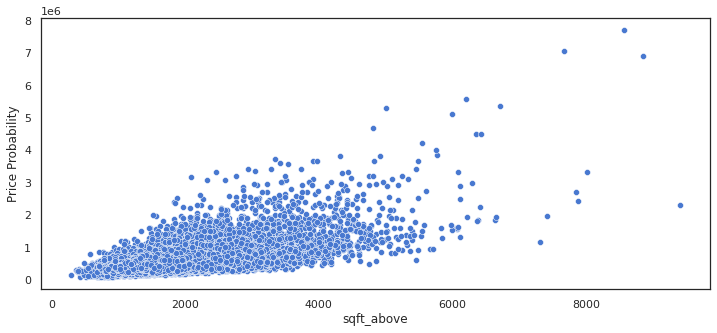

In [71]:
plt.figure(figsize = (12, 5))
c = sns.scatterplot(y = 'price', x = 'sqft_above', data = data)
c.set_ylabel('Price Probability')
plt.show()

The relationship is linear

# Price vs sqft_basement

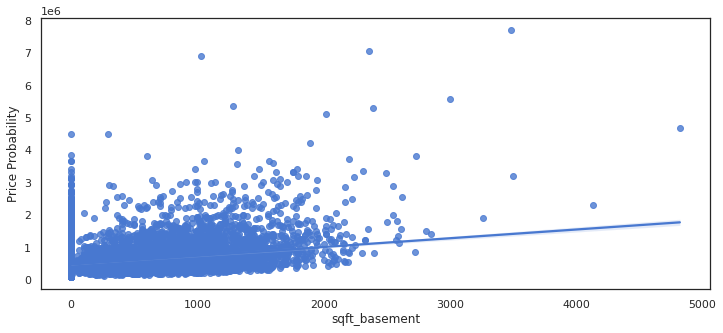

In [72]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'sqft_basement', data = data)
c.set_ylabel('Price Probability')
plt.show()

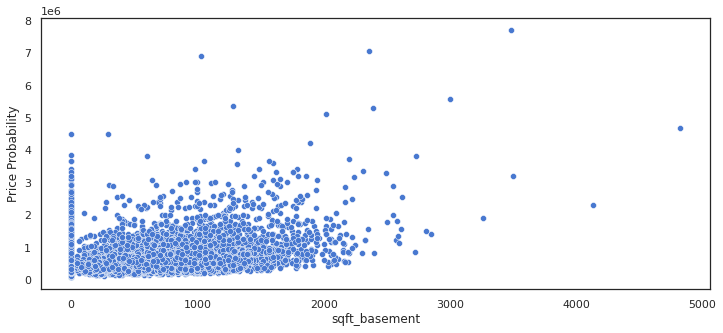

In [73]:
plt.figure(figsize = (12, 5))
c = sns.scatterplot(y = 'price', x = 'sqft_basement', data = data)
c.set_ylabel('Price Probability')
plt.show()

The relationship is close to linear.

# Price vs yr_built

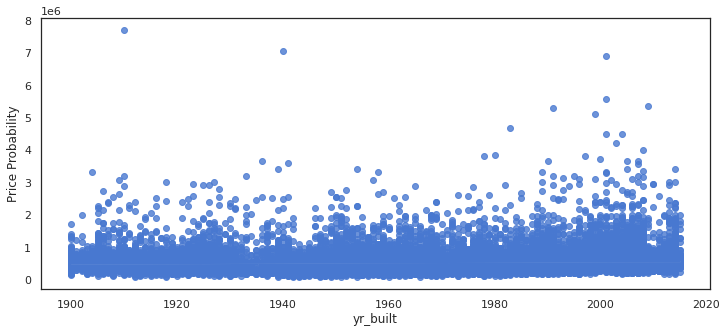

In [74]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'yr_built', data = data)
c.set_ylabel('Price Probability')
plt.show()

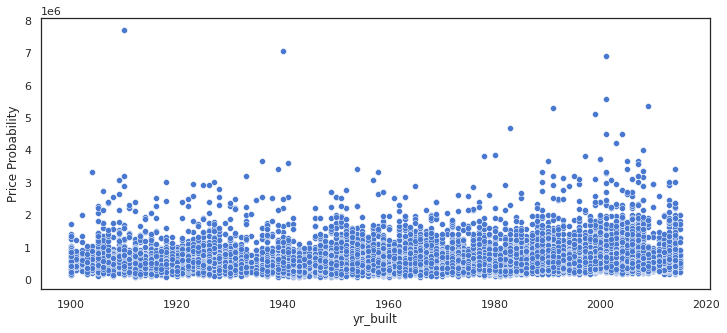

In [75]:
plt.figure(figsize = (12, 5))
c = sns.scatterplot(y = 'price', x = 'yr_built', data = data)
c.set_ylabel('Price Probability')
plt.show()

No relationship

# Price vs yr_renovated

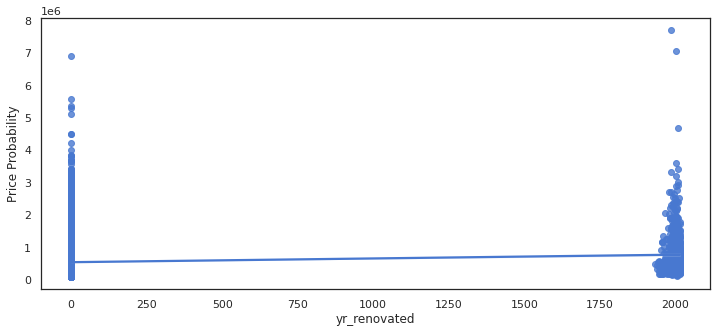

In [76]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'yr_renovated', data = data)
c.set_ylabel('Price Probability')
plt.show()

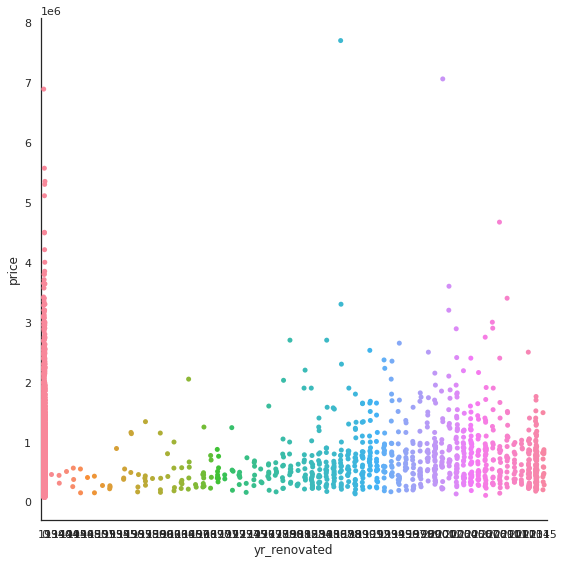

In [77]:
sns.catplot(y = 'price', x = 'yr_renovated', data = data, height = 8)
plt.show()

Relationship is not linear

# Price vs sqft_living15

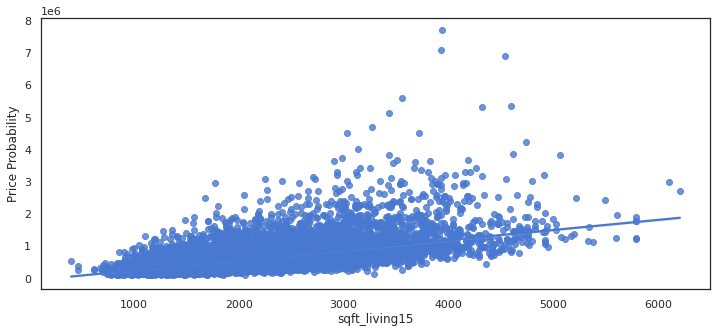

In [78]:
plt.figure(figsize = (12, 5))
c = sns.regplot(y = 'price', x = 'sqft_living15', data = data)
c.set_ylabel('Price Probability')
plt.show()

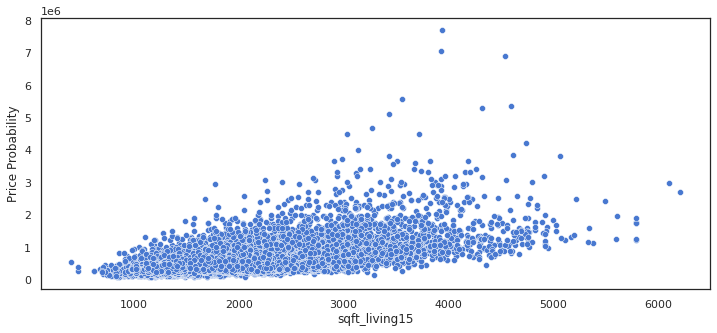

In [79]:
plt.figure(figsize = (12, 5))
c = sns.scatterplot(y = 'price', x = 'sqft_living15', data = data)
c.set_ylabel('Price Probability')
plt.show()

The relationship is linear

# Price vs date_day_of_week

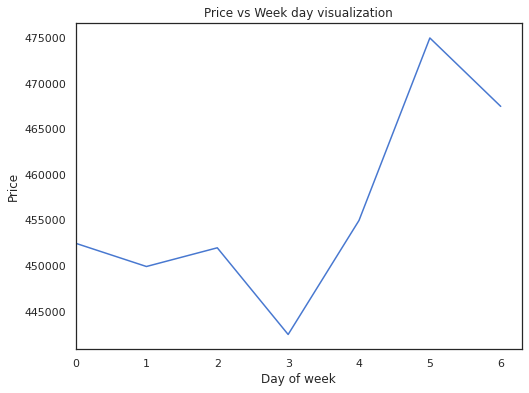

In [80]:
summary_month_avg_duration = pd.DataFrame(data.groupby(['date_day_of_week'])['price'].median()) # we use median inplace of mean cause of the presence of outliers
summary_month_avg_duration.reset_index(inplace = True)

fig, axes = plt.subplots(figsize=(8,6))
axes.plot(summary_month_avg_duration['date_day_of_week'], summary_month_avg_duration['price'])

axes.set_xlim(left=0)
axes.set_xlabel('Day of week')
axes.set_ylabel('Price')
axes.set_title('Price vs Week day visualization')
plt.show()

It can be seen that the price peaks on Fridays(5).

# Price vs date_month

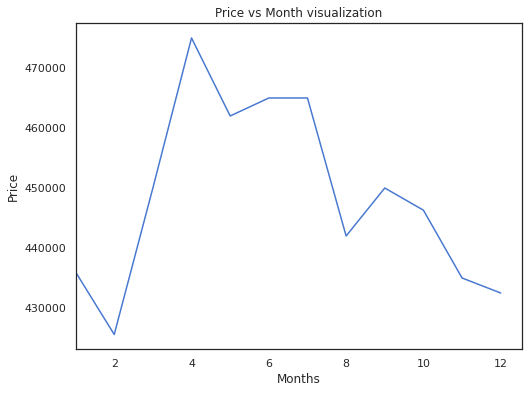

In [81]:
summary_month_avg_duration = pd.DataFrame(data.groupby(['date_month'])['price'].median())
summary_month_avg_duration.reset_index(inplace = True)

fig, axes = plt.subplots(figsize=(8,6))
axes.plot(summary_month_avg_duration['date_month'], summary_month_avg_duration['price'])

axes.set_xlim(left=1)
axes.set_xlabel('Months')
axes.set_ylabel('Price')
axes.set_title('Price vs Month visualization')
plt.show()

House price rises on Aprils(4).

# Price vs date_week_of_year

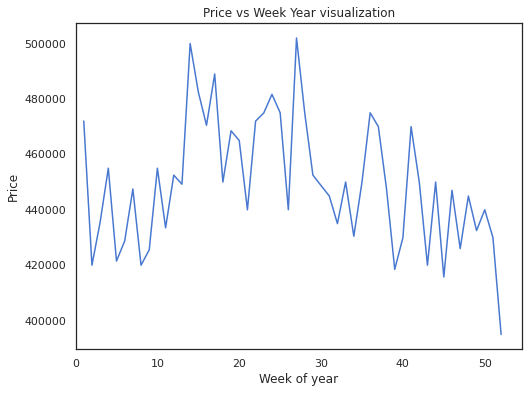

In [82]:
summary_month_avg_duration = pd.DataFrame(data.groupby(['date_week_of_year'])['price'].median())
summary_month_avg_duration.reset_index(inplace = True)

fig, axes = plt.subplots(figsize=(8,6))
axes.plot(summary_month_avg_duration['date_week_of_year'], summary_month_avg_duration['price'])

axes.set_xlim(left=0)
axes.set_xlabel('Week of year')
axes.set_ylabel('Price')
axes.set_title('Price vs Week Year visualization')
plt.show()

# Price vs date_year_quarter

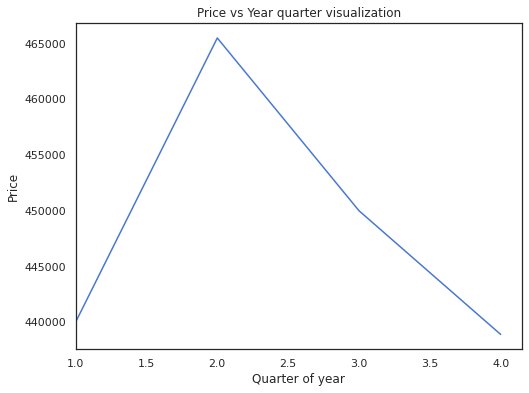

In [83]:
summary_month_avg_duration = pd.DataFrame(data.groupby(['date_year_quarter'])['price'].median())
summary_month_avg_duration.reset_index(inplace = True)

fig, axes = plt.subplots(figsize=(8,6))
axes.plot(summary_month_avg_duration['date_year_quarter'], summary_month_avg_duration['price'])

axes.set_xlim(left=1)
axes.set_xlabel('Quarter of year')
axes.set_ylabel('Price')
axes.set_title('Price vs Year quarter visualization')
plt.show()

The price of buildings goes up 2nd quarter of the first year.

## Visualize the most frequently occuring points on the logitude, latitude map

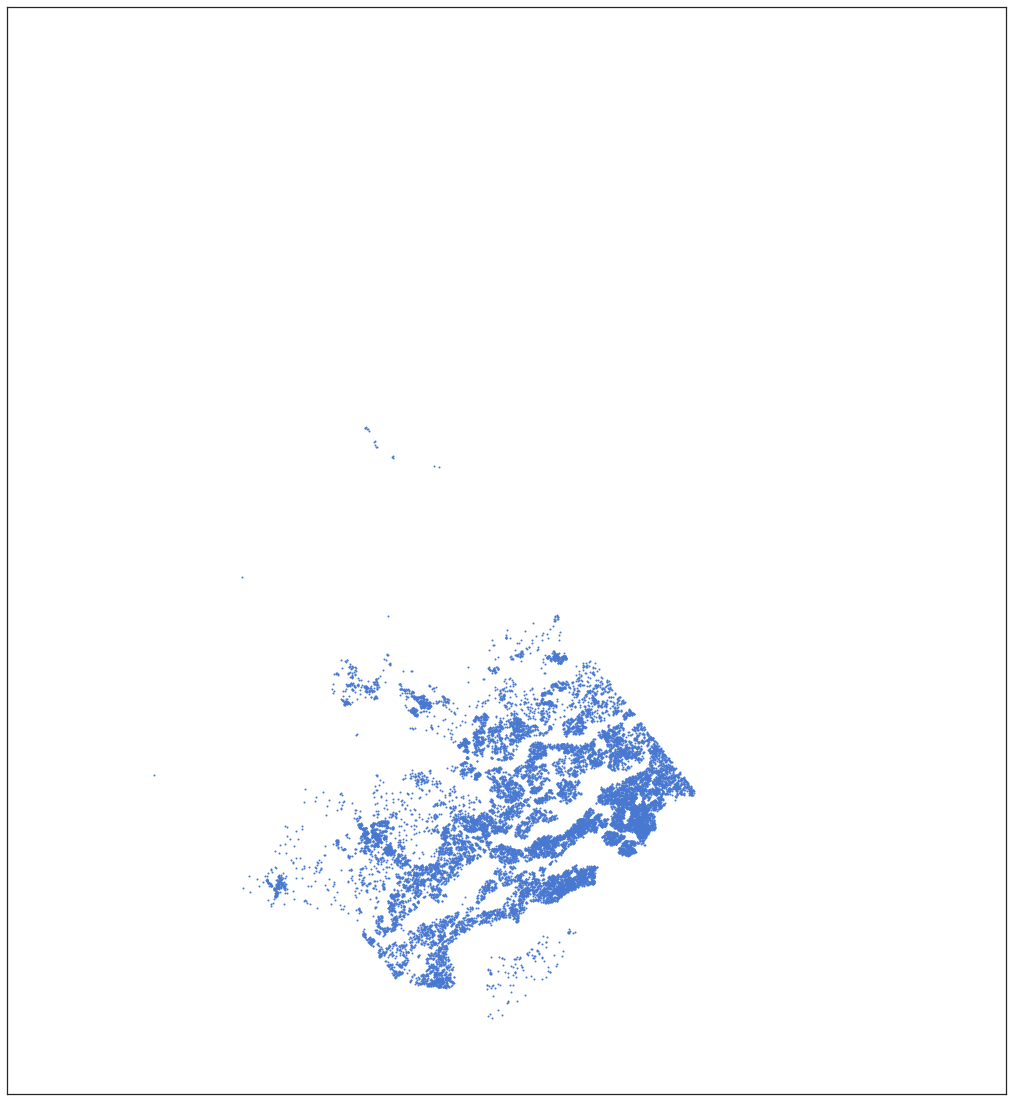

In [84]:
fig, ax = plt.subplots(figsize=(20,20))

# Set the limits of the map to the maximum and minimum coordinates
lat_min = 46.7
lat_max = 48.85
lon_min = -122.0
lon_max = -121.4

# Set the center of the map
center_lon = lon_min + lon_max / 2
center_lat = lat_min + lat_max / 2



# Create the basemap object
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            resolution='l',
            projection='tmerc',
            lat_0=center_lat,
            lon_0=center_lon)

long = np.array(data['long'])
lat = np.array(data['lat'])

x, y = m(long, lat)
m.plot(x, y, 'bo', markersize=1, alpha=1)

plt.show()

In [85]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'log_price',
       'date_day_of_week', 'date_day_name', 'date_month', 'date_month_name',
       'date_week_of_year', 'date_year_quarter'],
      dtype='object')

In [86]:
data.drop(['price', 'id', 'date', 'zipcode', 'date_day_name', 'date_month_name'], axis = 1, inplace = True)
data_cleaned = data.copy()
data_cleaned.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,log_price,date_day_of_week,date_month,date_week_of_year,date_year_quarter
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,12.309987,0,10,42,4
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,13.195616,1,12,50,4
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,12.100718,2,2,9,1
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000,13.311331,1,12,50,4
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,13.142168,2,2,8,1


# Feature Engineering

**One-hot Encode nominal variables and Label Encode the ordinal ones.**

In [87]:
# We will only one-hot encode as all the ordinal features has already being encoded.
data_cleaned = pd.get_dummies(data = data_cleaned, columns = ['bedrooms', 'waterfront', 'date_day_of_week', 
                                                              'date_month', 'date_year_quarter'])
print(data_cleaned.shape)
data_cleaned.head()

(21588, 55)


,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,log_price,date_week_of_year,bedrooms_0,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,bedrooms_33,waterfront_0,waterfront_1,date_day_of_week_0,date_day_of_week_1,date_day_of_week_2,date_day_of_week_3,date_day_of_week_4,date_day_of_week_5,date_day_of_week_6,date_month_1,date_month_2,date_month_3,date_month_4,date_month_5,date_month_6,date_month_7,date_month_8,date_month_9,date_month_10,date_month_11,date_month_12,date_year_quarter_1,date_year_quarter_2,date_year_quarter_3,date_year_quarter_4
0,1.00,1180,5650,1.0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,12.309987,42,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,2.25,2570,7242,2.0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,13.195616,50,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,1.00,770,10000,1.0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,12.100718,9,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,3.00,1960,5000,1.0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000,13.311331,50,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,2.00,1680,8080,1.0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,13.142168,8,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [88]:
# The longitude and latitude may be a bit noisy so let use round them up to 3 decimal place as new features
data_cleaned['long_round3'] = np.round(data_cleaned.long, 3)
data_cleaned['lat_round3'] = np.round(data_cleaned.lat, 3)

data_cleaned.drop(['long', 'lat'], axis = 1, inplace = True)

In [89]:
y = data_cleaned['log_price']
all_feats = data_cleaned.drop(['log_price'], axis = 1)
all_feats_checkpoint = all_feats.copy()

# Correlation

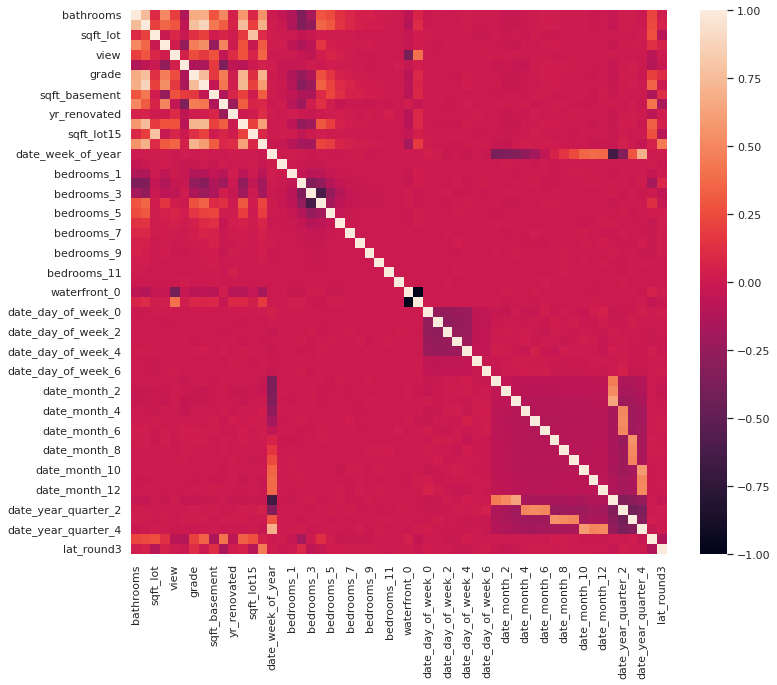

In [90]:
plt.figure(figsize=(12, 10))
corr_matrix = data_cleaned.corr()
sns.heatmap(corr_matrix)
plt.show()

In [91]:
corr_matrix.log_price.sort_values(ascending=False)

log_price              1.000000
grade                  0.703262
sqft_living            0.695187
sqft_living15          0.619757
sqft_above             0.601279
bathrooms              0.550450
lat_round3             0.450598
view                   0.346516
sqft_basement          0.317612
floors                 0.310163
bedrooms_4             0.226387
bedrooms_5             0.183801
waterfront_1           0.174828
yr_renovated           0.114782
sqft_lot               0.107012
sqft_lot15             0.091522
yr_built               0.079667
bedrooms_6             0.076562
long_round3            0.048659
date_year_quarter_2    0.041683
bedrooms_7             0.039869
condition              0.039764
date_month_4           0.030927
bedrooms_8             0.028275
date_month_6           0.020396
bedrooms_9             0.018243
date_month_5           0.012134
bedrooms_10            0.011921
date_day_of_week_0     0.010541
date_month_7           0.007853
date_day_of_week_5     0.007289
date_day

In [92]:
baseline_feats = data_cleaned[['grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms', 'lat_round3',
                               'view', 'sqft_basement', 'floors', 'bedrooms_4', 'bedrooms_5', 'waterfront_1',
                               'yr_renovated', 'sqft_lot', 'sqft_lot15', 'yr_built', 'bedrooms_6', 'long_round3',
                               'date_year_quarter_2', 'bedrooms_7', 'condition', 'date_month_4', 'bedrooms_8',
                               'date_month_6', 'bedrooms_9', 'date_month_5', 'bedrooms_10', 'date_day_of_week_0',
                               'date_month_7', 'date_day_of_week_5', 'date_day_of_week_6', 'date_day_of_week_4',
                               'bedrooms_33', 'date_month_3']]
baseline_feats.head()
baseline_feats_checkpoint = baseline_feats.copy()

**Now, we have the all_features and baseline_features. We will check for multicollinearity in both dataframe to see the relevant features for our linear models. So we can train them on the relevant ones.**

# Check for Multicollinearity

**Common ways to check for Multicollinearity**
1. VIF = 1, Very less Multicollinearity
2. VIF < 5, Moderate Multicollinearity
3. VIF > 5, Extreme Multicollinearity (This is what we want to avoid)

In [93]:
def calculate_VIF(data):
    
    """Function to calculte the presence of Multicollinearity between independent features"""
    
    vif_df = pd.DataFrame(columns = ['Var', 'VIF'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1 / (1-r_squared), 2)
        vif_df.loc[i] = [x_var_names[i], vif]
        
    return vif_df.sort_values(by = 'VIF', axis = 0, ascending = False, inplace = False)

calculate_VIF(baseline_feats)

/tmp/ipykernel_25248/2332580851.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1 / (1-r_squared), 2)


,Var,VIF
25,date_month_5,inf
23,date_month_6,inf
21,date_month_4,inf
18,date_year_quarter_2,inf
1,sqft_living,2753916.84
3,sqft_above,2068657.28
7,sqft_basement,149729.88
17,long_round3,133293.27
5,lat_round3,120094.96
15,yr_built,8664.21


In [94]:
%%time
# Filter the features with high Multicollinearity
base_no_multicol = baseline_feats.drop(['sqft_living', 'sqft_above', 'yr_built', 'grade', 
                                        'date_year_quarter_2', 'condition', 'lat_round3', 
                                        'long_round3', 'bathrooms', 'sqft_living15'], axis = 1)
calculate_VIF(base_no_multicol)

CPU times: user 4.68 s, sys: 2.28 s, total: 6.95 s
Wall time: 1.83 s


,Var,VIF
8,sqft_lot15,3.26
7,sqft_lot,3.10
2,floors,3.04
1,sqft_basement,1.64
0,view,1.43
5,waterfront_1,1.21
6,yr_renovated,1.06
20,date_day_of_week_6,1.02
10,bedrooms_7,1.01
12,bedrooms_8,1.01


# All Features Dataframe

In [95]:
%%time
calculate_VIF(all_feats)

/tmp/ipykernel_25248/2332580851.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1 / (1-r_squared), 2)


CPU times: user 54.6 s, sys: 13.1 s, total: 1min 7s
Wall time: 17.5 s


,Var,VIF
27,waterfront_0,inf
32,date_day_of_week_3,inf
23,bedrooms_9,inf
24,bedrooms_10,inf
25,bedrooms_11,inf
26,bedrooms_33,inf
28,waterfront_1,inf
29,date_day_of_week_0,inf
30,date_day_of_week_1,inf
31,date_day_of_week_2,inf


In [96]:
all_no_multicol = all_feats.drop(['sqft_living', 'sqft_above', 'sqft_basement', 'date_week_of_year'], axis = 1)
calculate_VIF(all_no_multicol)

/tmp/ipykernel_25248/2332580851.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1 / (1-r_squared), 2)


,Var,VIF
25,date_day_of_week_0,inf
29,date_day_of_week_4,inf
22,bedrooms_33,inf
23,waterfront_0,inf
24,waterfront_1,inf
40,date_month_9,inf
26,date_day_of_week_1,inf
27,date_day_of_week_2,inf
28,date_day_of_week_3,inf
30,date_day_of_week_5,inf


# Model Building & Evaluation

In [97]:
def train_error(model, X_train, Y_train):
    
    """Function to calculate the train root mean squared error and r_squared 
    for an already fit model
    """
    
    train_preds = model.predict(X_train)
    r_squared = r2_score(Y_train, train_preds)
    mse = mean_squared_error(Y_train, train_preds)
    rmse = np.sqrt(mse)
    return r_squared, rmse, train_preds

def val_error(model, X_test, Y_test):
    
    """Function to calculate the test root mean squared error for an 
    already fit model
    """
    
    test_preds = model.predict(X_test)
    r_squared = r2_score(Y_test, test_preds)
    mse = mean_squared_error(Y_test, test_preds)
    rmse = np.sqrt(mse)
    return r_squared, rmse, test_preds

def selectFeatures(score, num_to_select, X_train, X_test, y_train):
    
    """Function to select important features
    """
    
    fs = SelectKBest(score_func = score, k = num_to_select)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def cal_metrics(X_train, Y_train, X_test, Y_test, model, normalized=True):
    
    """Normalize or not normalized model and then fit and returns the RMSE of 
    in-sample error and out-of-sample error"""
    
    if normalized:
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model_norm = model.fit(X_train_scaled, Y_train)
        train_errors = train_error(model_norm, X_train_scaled, Y_train)[1]
        valid_errors = val_error(model_norm, X_test_scaled, Y_test)[1]
        r_squared = val_error(model_norm, X_test_scaled, Y_test)[0]
        return train_errors, valid_errors, r_squared, model_norm, scaler

    if not normalized:
        model_not_norm = model.fit(X_train, Y_train)
        train_errors = train_error(model_not_norm, X_train, Y_train)[1]
        valid_errors = val_error(model_not_norm, X_test, Y_test)[1]
        return train_errors, valid_errors
    
def cross_validation_score(model, randm_st=42, df=all_feats, cols = all_feats.columns):
    
    """
    Function to calculate the Repeated k fold cross validation on the basis of target
    and prints the R_squared and Root mean squared error of the train and test set.
    
    Args:
        ml_model (numpy array) : ml_model for predictions
        random_st (int) : random_st is the random state for Kfold
        df (dataframe) : dataframe to process
        cols (string) : cols are the column names
    
    Returns:
        cv_scores (float) : cross validation scores
    """
    
    i = 1
    x1 = df.copy()
    x1 = df[cols]
    # train_error = []
    valid_error = []
    # r_squared_score = []
    
    rkf = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
    for train_idx, val_idx in rkf.split(x1, y):
        # Split the data
        xtr, xvl = x1.iloc[train_idx], x1.iloc[val_idx]
        ytr, yvl = y.iloc[train_idx], y.iloc[val_idx]
        #print(xtr.shape, xvl.shape, ytr.shape, yvl.shape)

        train_errors, valid_errors, r_squared, _, __= cal_metrics(X_train=xtr, Y_train=ytr, X_test=xvl, Y_test=yvl, 
                                                            model=model)
        train_test_ratio = (round(valid_errors/train_errors, 1) * 10)

        # Generate report
        msg = ""
        msg += f"(train_error) --> {train_errors:.5f} | (val_error) --> {valid_errors:.5f} | (r2_score) --> {r_squared:.5f}\nThe Train/Test Error signifies that the Test Error is {train_test_ratio}% worse from the train error.\n"
        print(f"{msg}")
        # train_error.append(train_errors)
        valid_error.append(valid_errors)
        i += 1
        
    return valid_errors

In [98]:
cross_validation_score(LinearRegression(), randm_st=42, df=base_no_multicol, 
                       cols = base_no_multicol.columns)

(train_error) --> 0.42083 | (val_error) --> 0.42827 | (r2_score) --> 0.34987
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

(train_error) --> 0.42189 | (val_error) --> 0.41856 | (r2_score) --> 0.37057
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

(train_error) --> 0.42147 | (val_error) --> 0.42231 | (r2_score) --> 0.36251
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

(train_error) --> 0.42152 | (val_error) --> 0.42200 | (r2_score) --> 0.34943
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

(train_error) --> 0.42194 | (val_error) --> 0.41833 | (r2_score) --> 0.38337
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

(train_error) --> 0.42099 | (val_error) --> 0.42669 | (r2_score) --> 0.34192
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

(tra

0.42785424009848616

In [99]:
cross_validation_score(LinearRegression(), randm_st=42, df=all_no_multicol, 
                       cols = all_no_multicol.columns)

(train_error) --> 0.25793 | (val_error) --> 24912902591.45245 | (r2_score) --> -2199946812220024291328.00000
The Train/Test Error signifies that the Test Error is 965875881123.0% worse from the train error.

(train_error) --> 0.25808 | (val_error) --> 0.26136 | (r2_score) --> 0.75457
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

(train_error) --> 0.25821 | (val_error) --> 0.26059 | (r2_score) --> 0.75728
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

(train_error) --> 0.25865 | (val_error) --> 34479103697.08600 | (r2_score) --> -4342966573213855252480.00000
The Train/Test Error signifies that the Test Error is 1333016271856.0% worse from the train error.

(train_error) --> 0.25788 | (val_error) --> 0.26321 | (r2_score) --> 0.75588
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

(train_error) --> 0.25815 | (val_error) --> 0.26074 | (r2_score) --> 0.75425
The Trai

0.2575626806507048

This shows that the Linear model performed best on the all_no_multicol data set. Therefore, we will work with this.

# Feature Selection

In [100]:
X_train, X_test, y_train, y_test = train_test_split(all_no_multicol, y, test_size = 1/3, random_state = 43)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14392, 50) (14392,) (7196, 50) (7196,)


In [101]:
X_train_fs, X_test_fs, fs = selectFeatures(score = mutual_info_regression, 
                                           num_to_select = 34,
                                           X_train = X_train_scaled, 
                                           X_test = X_test_scaled, 
                                           y_train = y_train)

model_mut_reg = LinearRegression()
model_mut_reg.fit(X_train_fs, y_train)

_, train_rmse, train_preds = train_error(model_mut_reg, X_train_fs, y_train)
r_squared, test_rmse, test_preds = val_error(model_mut_reg, X_test_fs, y_test)

print(f"R_squared: {r_squared:.5f}, Train error: {train_rmse:.5f}, Val error: {test_rmse:.5f}")

R_squared: 0.75498, Train error: 0.25914, Val error: 0.25911


In [102]:
X_train_fs, X_test_fs, fs = selectFeatures(score = f_regression, 
                                           num_to_select = 34,
                                           X_train = X_train_scaled, 
                                           X_test = X_test_scaled, 
                                           y_train = y_train)

model_f_reg = LinearRegression()
model_f_reg.fit(X_train_fs, y_train)

_, train_rmse, train_preds = train_error(model_f_reg, X_train_fs, y_train)
r_squared, test_rmse, test_preds = val_error(model_f_reg, X_test_fs, y_test)

print(f"R_squared: {r_squared:.5f}, Train error: {train_rmse:.5f}, Val error: {test_rmse:.5f}")

R_squared: 0.75606, Train error: 0.25876, Val error: 0.25853


/home/daniel/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


In [103]:
# Build the final model
final_model = LinearRegression()
final_model.fit(X_train_fs, y_train)

_, train_rmse, train_preds = train_error(final_model, X_train_fs, y_train)
r_squared, test_rmse, test_preds = val_error(final_model, X_test_fs, y_test)

print(f"R_squared: {r_squared:.5f}, Train error: {train_rmse:.5f}, Val error: {test_rmse:.5f}")

R_squared: 0.75606, Train error: 0.25876, Val error: 0.25853


In [104]:
# compare the actual price and predicted price
out = pd.DataFrame(y_test[0:15])
out = out.rename(columns = {'log_price':'Actual_price'})
out['Predicted_price'] = test_preds[0:15]
out['Difference'] = out['Predicted_price'] - out['Actual_price']
out

,Actual_price,Predicted_price,Difference
15933,13.171155,13.226141,0.054986
16926,13.124363,12.968424,-0.155940
9215,13.910822,13.778553,-0.132269
10930,12.785494,12.861478,0.075984
436,13.490474,13.783570,0.293096
5555,12.980802,12.980837,0.000034
16775,13.279369,12.639351,-0.640018
9244,13.744110,13.581507,-0.162603
18181,12.478010,12.519185,0.041175
16378,13.171155,13.074027,-0.097129


There is no much difference between the predicted and the actual price, we can use this model for predictions.